# Data Understanding - Server Logs
### 1. Nguồn dữ liệu
### 2. Mô tả trường thông tin
#### Dữ liệu log có cấu trúc gồm các trường chính:
| **Tên Trường**        | **Kiểu Dữ Liệu**       | **Mô Tả Ý Nghĩa**                                                      |
|-----------------------|------------------------|-------------------------------------------------------------------------|
| `std`                 | String                 | Loại log: `stdout` (log bình thường) hoặc `stderr` (log lỗi).                |
| `remote_address`      | String                 | Địa chỉ IP của máy khách.                                      |
| `remote_user`         | String                 | Tên người dùng (dấu `-` nếu không có thông tin).     |
| `datetime`            | Datetime               | Thời gian và ngày giờ của request, định dạng theo chuẩn ISO8601: `yyyy-MM-dd'T'HH:mm:ss.SSSSSSSSS+hh:mm`|
| `method`              | String                 | Phương thức HTTP (ví dụ: GET, POST, PUT, DELETE,...)                 |
| `path`                | String                 | Đường dẫnđược truy cập trên máy chủ (ví dụ: `/status`, `/api/data`)           |
| `header`              | String                 | Phiên bản giao thức HTTP (ví dụ: `HTTP/1.1`).                           |
| `status`              | Integer                | Mã trạng thái HTTP trả về (ví dụ: `200`, `404`, `500`)                |
| `bytes_sent`          | Integer                | Số byte dữ liệu đã được gửi trong phản hồi (response)                |
| `referer`             | String                 | URL nguồn (referer) của request           |
| `user_agent`          | String                 | Thông tin về trình duyệt hoặc công cụ gửi request. |
### 3. Tách các dòng log thành các trường dữ liệu
#### Ví dụ ta có dữ liệu như sau:<br>2024-11-30T13:51:41.272335253+07:00 stdout F 127.0.0.1 - - [30/Nov/2024:06:51:41 +0000] "GET /status HTTP/1.1" 200 1164 "-" "kong-ingress-controller/3.3.1"<br>2024-11-30T13:51:42.210291667+07:00 stderr F 10.244.3.1 - - [30/Nov/2024:06:51:42 +0000] "GET /status HTTP/1.1" 200 1165 "-" "kube-probe/1.27"<br>2024-11-30T13:51:42.213094133+07:00 stderr F 10.244.3.1 - - [30/Nov/2024:06:51:42 +0000] "GET /status/ready HTTP/1.1" 200 19 "-" "kube-probe/1.27"

#### Mục tiêu là tách các trường dữ liệu và đưa về dạng:<br>
| std    | remote_address | remote_user | datetime                    | method | path          | header   | status | bytes_sent | referer | user_agent                     |
|--------|----------------|-------------|-----------------------------|--------|---------------|----------|--------|------------|---------|--------------------------------|
| stdout | 127.0.0.1      | -           | 30/Nov/2024:06:51:41 +0000 | GET    | /status       | HTTP/1.1 | 200    | 1164       | -       | kong-ingress-controller/3.3.1 |
| stderr | 10.244.3.1     | -           | 30/Nov/2024:06:51:42 +0000 | GET    | /status       | HTTP/1.1 | 200    | 1165       | -       | kube-probe/1.27               |
| stderr | 10.244.3.1     | -           | 30/Nov/2024:06:51:42 +0000 | GET    | /status/ready | HTTP/1.1 | 200    | 19         | -       | kube-probe/1.27               |
#### Để đạt được các trường dữ liệu đó, ta cần thiết kế biểu thức regex tương ứng: <br> 
```regex
^
\S+                              # Phần đầu dòng, bỏ qua chuỗi không chứa khoảng trắng.
 (?P<std>\S+)                    # Nhóm `std`: stdout/stderr.
 \S+                             # Bỏ qua một chuỗi không chứa khoảng trắng.
 (?P<remote_address>\d+\.\d+\.\d+\.\d+) # Nhóm `remote_address`: Địa chỉ IP (IPv4).
 -                               # Ký tự gạch ngang.
 (?P<remote_user>[^ ]*)          # Nhóm `remote_user`: Tên người dùng (hoặc trống: `-`).
 \[(?P<datetime>[^\]]+)\]        # Nhóm `datetime`: Thời gian (nằm trong dấu `[]`).
 "(?P<method>\w+)                # Nhóm `method`: Phương thức HTTP (GET, POST,...).
  (?P<path>[^\s]+)               # Nhóm `path`: Đường dẫn truy cập.
  (?P<header>[^\"]+)"            # Nhóm `header`: Phiên bản giao thức (HTTP/1.1).
 (?P<status>\d+)                 # Nhóm `status`: Mã trạng thái HTTP (200, 404,...).
 (?P<bytes_sent>\d+)             # Nhóm `bytes_sent`: Số byte đã gửi.
 "(?P<referer>[^\"]*)"           # Nhóm `referer`: URL nguồn (có thể trống: `-`).
 "(?P<user_agent>[^\"]*)"        # Nhóm `user_agent`: Thông tin User-Agent.

In [30]:
import sys
import os
module_path = r"D:\CODING\Project\Server Log Analysis\notebooks\Data Understanding"
if module_path not in sys.path:
    sys.path.append(module_path)
from logtransform import LogTransform

In [31]:
source_path = r"D:\CODING\Project\Server Log Analysis\data\raw\server_log.txt"
destination_path = r"D:\CODING\Project\Server Log Analysis\data\interim\parsed_logs.csv"
log_pattern= r'^\S+ (?P<std>\S+) \S+ (?P<remote_address>\d+\.\d+\.\d+\.\d+) - (?P<remote_user>[^ ]*) \[(?P<datetime>[^\]]+)\] "(?P<method>\w+) (?P<path>[^\s]+) (?P<header>[^\"]+)" (?P<status>\d+) (?P<bytes_sent>\d+) "(?P<referer>[^\"]*)" "(?P<user_agent>[^\"]*)"'

In [32]:
logtransform = LogTransform(source_path)
df = logtransform.read_log_file(log_pattern)
df = logtransform.transform(df)

df.to_csv(destination_path)

D:\CODING\Project\Server Log Analysis\notebooks\Data Understanding\logtransform.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['std'] = df['std'].replace({'stdout': 0, 'stderr': 1})
D:\CODING\Project\Server Log Analysis\notebooks\Data Understanding\logtransform.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['method'] = df['method'].replace({'GET': 0, 'POST': 1})


In [33]:
df.head()

,std,remote_address,datetime,method,path,status,bytes_sent,referer,user_agent,day,hour,month
0,0,127.0.0.1,2024-11-30 06:51:41+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,6,11
1,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status,200,1165,-,kube-probe/1.27,30,6,11
2,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status/ready,200,19,-,kube-probe/1.27,30,6,11
3,0,127.0.0.1,2024-11-30 06:51:44+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,6,11
4,0,127.0.0.1,2024-11-30 06:51:47+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,6,11


### 4. Minh họa dữ liệu

In [34]:
import sys
import os
module_path = r"D:\CODING\Project\Server Log Analysis\notebooks\Data Understanding"
if module_path not in sys.path:
    sys.path.append(module_path)
from visualize import Visualize

In [35]:

log_path = r"D:\CODING\Project\Server Log Analysis\data\interim\parsed_logs.csv"
visualizer = Visualize(log_path)

#### Số lượng lỗi và Request hợp lệ qua thời gian

Số lượng lỗi và request hợp lệ qua từng giờ:
request_type  Hợp lệ  Lỗi
hour                     
0               2041   16
1               2043   20
2               1931   18
3               1987   28
4               2143   20
5               2168   16
6               2357   29
7               4405   55
8               4407   76
9               4293   53
10              4319   70
11              4057   45
12              4038   48
13              4187   45
14              2653   29
15              2051   16
16              2156   24
17              2153   25
18              2048   24
19              2050   16
20              2279   15
21              1923   24
22              2042   17
23              1926   25


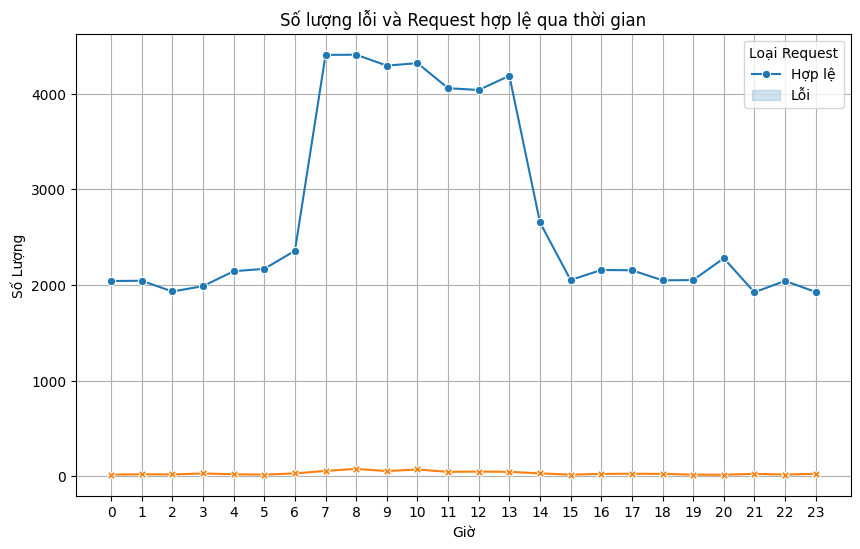

In [36]:

visualizer.plot_errors_over_time()

Dễ thấy có sự gia tăng về số request và lỗi vào giờ cao điểm:<br>
Giai đoạn từ sau 6h đến 13h nhận được rất nhiều request, tuy vậy lượng request tăng đột biến nhưng lượng lỗi dù cũng tăng nhẹ nhưng không đáng kể so với tổng thể.

#### Phân bố các loại request

Phân bố các loại request:
method
0    65067
1     1344
Name: count, dtype: int64


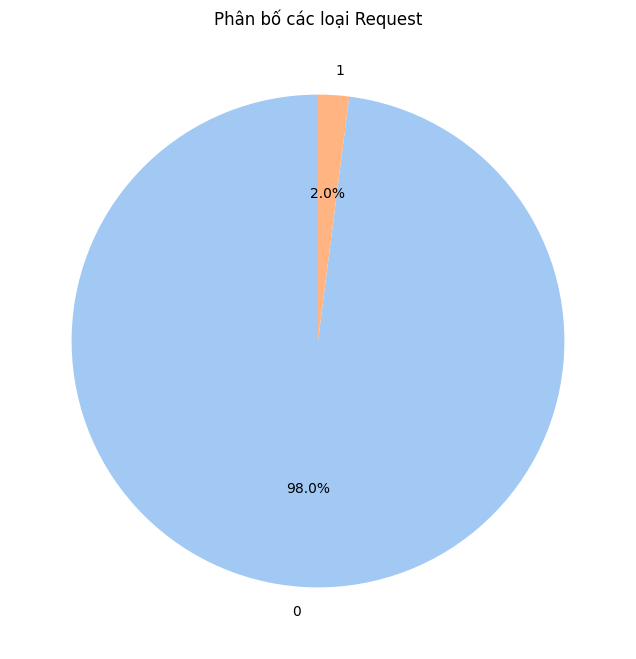

In [37]:
visualizer.plot_request_distribution()

GET là loại request chiếm ưu thế, đây là loại request phổ biến trong các hệ thống, cho phép người dùng lấy dữ liệu mà không thay đổi trạng thái hệ thống.<br>
Các loại request khác như POST PUT DELETE chiếm tỉ lệ tương đối thấp

#### Lượng dữ liệu gửi đi mỗi giờ

Tổng lượng dữ liệu gửi đi mỗi giờ:
hour
0     24300140
1     24683859
2      3362500
3      3321619
4     43506576
5     48119969
6     34155199
7     82319314
8     33816224
9     47969084
10    35688855
11    30348109
12    30578718
13    64562994
14    19769433
15    25082630
16    41140657
17    46004094
18    25453639
19    26412105
20    69822440
21     1827480
22    24875417
23     2020663
Name: bytes_sent, dtype: int64


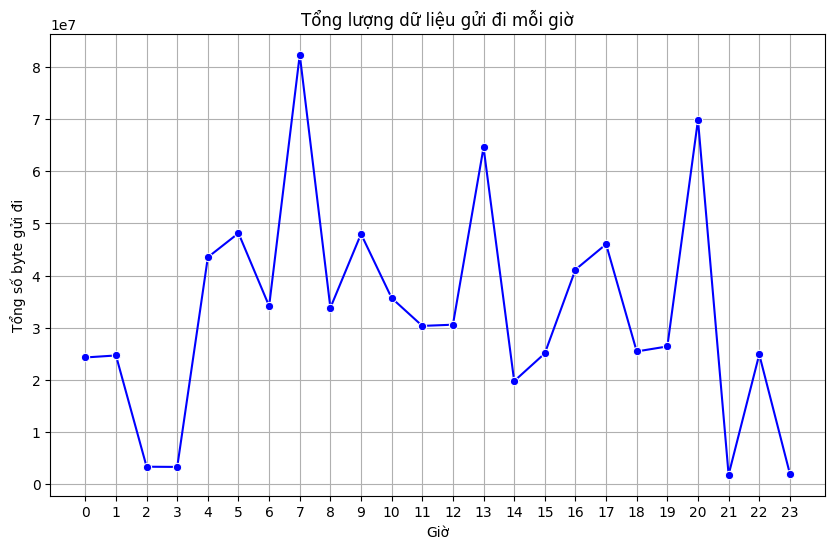

In [38]:
visualizer.plot_bytes_sent_per_hour()

Lượng dữ liệu gửi đi có xu hướng tăng vào ban ngày, đặc biệt là vào 7h, 8h và 20h.<br>
Vào ban đêm, lượng dữ liệu gửi đi giảm đáng kể.

### Phân bố các loại user-agent

Số lượng log theo các loại user agent:
kong-ingress-controller/3.3.1: 37750
kube-probe/1.27: 22650
otelcol-contrib/0.89.0: 3744
okhttp/4.12.0: 943
python-requests/2.32.2: 608
VTHome_Dev/6 CFNetwork/1568.200.51 Darwin/24.1.0: 499
VTHome_Dev/2 CFNetwork/1485 Darwin/23.1.0: 66
VTHome_Dev/6 CFNetwork/1498.700.2 Darwin/23.6.0: 47
VTHome_Dev/13 CFNetwork/1568.200.51 Darwin/24.1.0: 36
HiRangDong/36 CFNetwork/1568.200.51 Darwin/24.1.0: 20


D:\CODING\Project\Server Log Analysis\notebooks\Data Understanding\visualize.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=user_agent_counts.index, x=user_agent_counts.values, palette="viridis", orient='h')


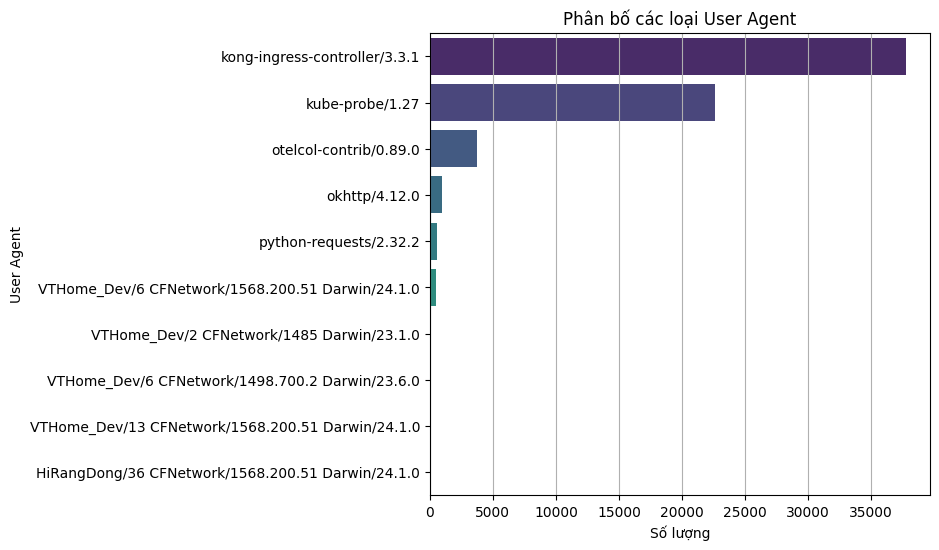

In [39]:
visualizer.plot_user_agent_distribution()

Các công cụ giám sát như kong-ingress-controller và kube-probe có số lượng log lớn<br>
=> Bình thường trong môi trường hệ thống vì chúng tham gia vào việc kiểm tra và theo dõi tình trạng của hệ thống.
Các user agent như okhttp, python-requests, và VTHome_Dev có thể là các ứng dụng hoặc thiết bị người dùng.<br>
=> Những user agent ít hơn này có thể là ứng dụng thử nghiệm hoặc các thiết bị ít được sử dụng, ví dụ như ứng dụng thử nghiệm nhà thông minh (VTHome_Dev) hoặc bóng đèn thông minh (HiRangDong)

#### Phân loại log level và thống kê cho từng loại

Số lượng log từng loại:
log_level
INFO     65657
ERROR      656
FATAL       98
Name: count, dtype: int64


D:\CODING\Project\Server Log Analysis\notebooks\Data Understanding\visualize.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=log_level_counts.index, y=log_level_counts.values, palette="viridis")


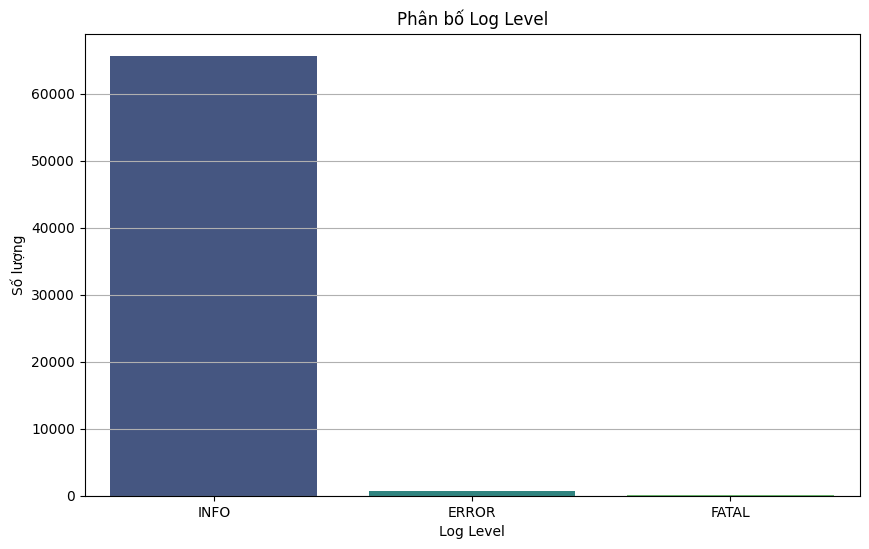

In [40]:
visualizer.plot_log_level()

Phân bố log level cho thấy hệ thống đang hoạt động ổn định với số lượng lỗi thấp. Tuy nhiên, các lỗi hoặc cảnh báo cần phải được phân tích để đảm bảo rằng chúng không ảnh hưởng đến tính ổn định hoặc hiệu suất của hệ thống trong dài hạn.

### Ta cùng phân tích các user agent ngoài các công cụ điều khiển

In [41]:
import pandas as pd

log_path = r'D:\CODING\Project\Server Log Analysis\data\interim\parsed_logs.csv'
log_df = pd.read_csv(log_path)

user_agent_counts = log_df['user_agent'].value_counts()
excluded_agents = ['kong-ingress-controller/3.3.1', 'otelcol-contrib/0.89.0', 'kube-probe/1.27']
rare_user_agents = user_agent_counts[~user_agent_counts.index.isin(excluded_agents)]
rare_user_agents_data = log_df[log_df['user_agent'].isin(rare_user_agents.index)]
rare_user_agents_data.to_csv(r'D:\CODING\Project\Server Log Analysis\data\interim\rare_user_agents.csv', index=False)

In [42]:
rare_visualizer = Visualize(r'D:\CODING\Project\Server Log Analysis\data\interim\rare_user_agents.csv')

Số lượng log theo các loại user agent:
okhttp/4.12.0: 943
python-requests/2.32.2: 608
VTHome_Dev/6 CFNetwork/1568.200.51 Darwin/24.1.0: 499
VTHome_Dev/2 CFNetwork/1485 Darwin/23.1.0: 66
VTHome_Dev/6 CFNetwork/1498.700.2 Darwin/23.6.0: 47
VTHome_Dev/13 CFNetwork/1568.200.51 Darwin/24.1.0: 36
HiRangDong/36 CFNetwork/1568.200.51 Darwin/24.1.0: 20
Mozilla/5.0 (iPhone; CPU iPhone OS 16_3_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) CriOS/131.0.6778.73 Mobile/15E148 Safari/604.1: 7
lua-resty-http/0.06 (Lua) ngx_lua/10020: 6
VTHome_Dev/21 CFNetwork/1568.200.51 Darwin/24.1.0: 6


D:\CODING\Project\Server Log Analysis\notebooks\Data Understanding\visualize.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=user_agent_counts.index, x=user_agent_counts.values, palette="viridis", orient='h')


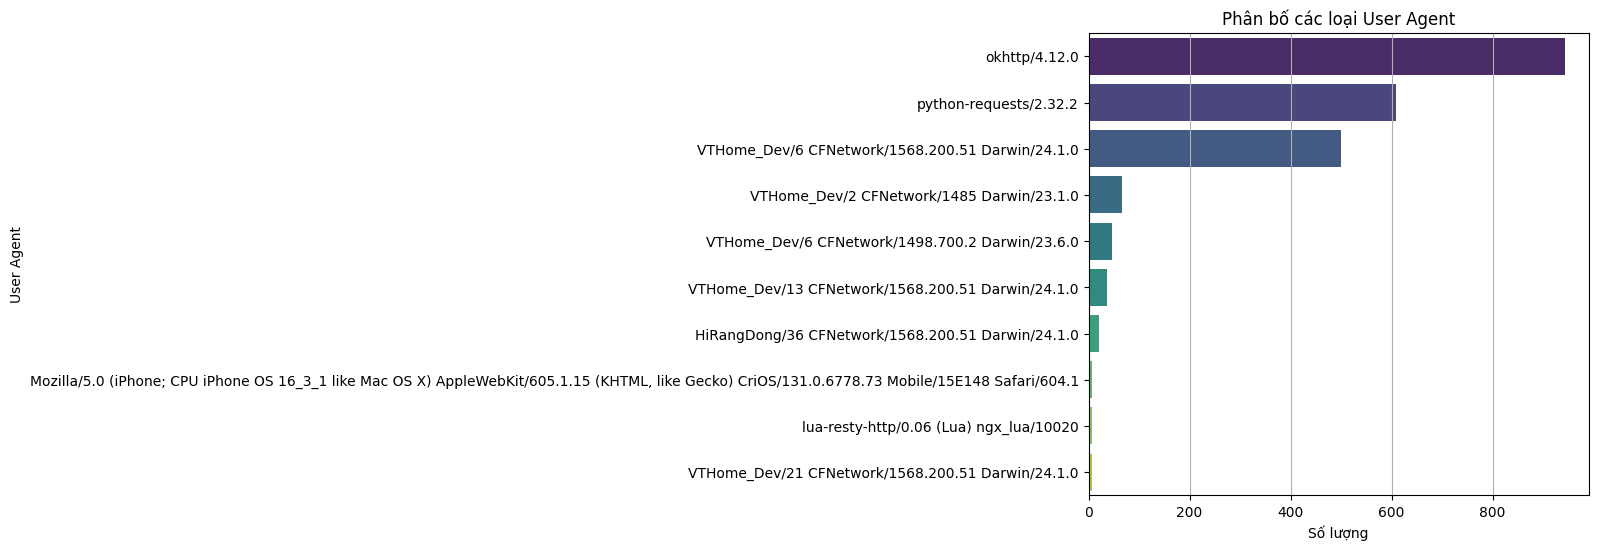

In [43]:
rare_visualizer.plot_user_agent_distribution()

Phân bố các loại request:
method
1    1344
0     923
Name: count, dtype: int64


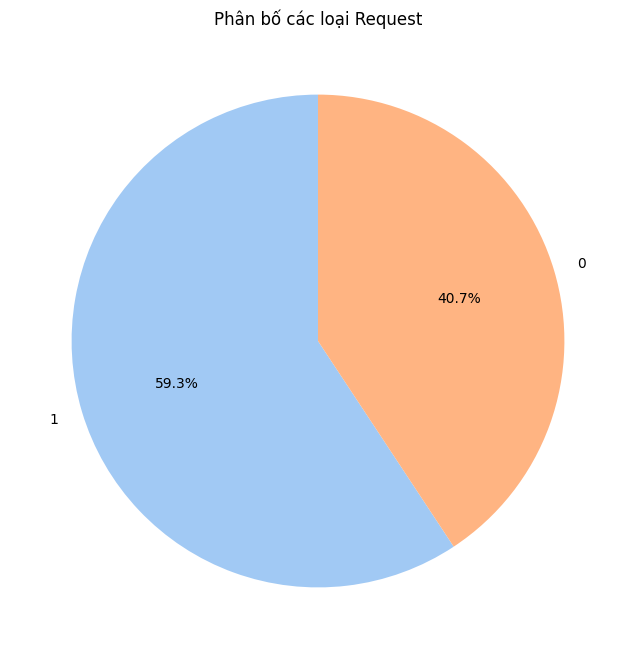

In [44]:
rare_visualizer.plot_request_distribution()

Số lượng lỗi và request hợp lệ qua từng giờ:
request_type  Hợp lệ  Lỗi
hour                     
0                  4   16
1                  4   20
2                  3   18
3                 67   28
4                  6   20
5                  7   16
6                  3   29
7                162   55
8                428   76
9                233   53
10               326   70
11                82   45
12                60   48
13                31   45
14                30   29
15                10   16
16                32   24
17                 3   25
18                 5   24
19                 2   16
20                 5   15
21                 3   24
22                 2   17
23                 5   25


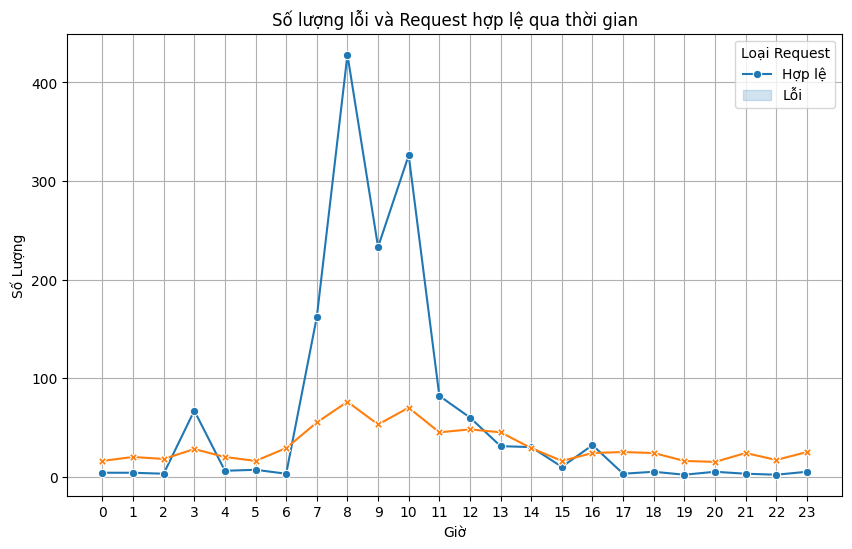

In [45]:
rare_visualizer.plot_errors_over_time()

Số lượng log từng loại:
log_level
INFO     1513
ERROR     656
FATAL      98
Name: count, dtype: int64


D:\CODING\Project\Server Log Analysis\notebooks\Data Understanding\visualize.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=log_level_counts.index, y=log_level_counts.values, palette="viridis")


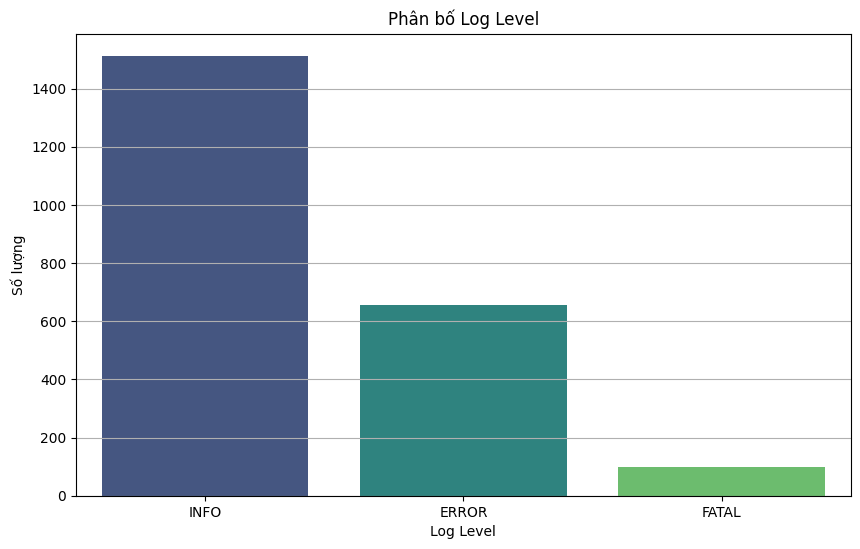

In [46]:
rare_visualizer.plot_log_level()